This code should do the following:<br>
XXX 1) Take an input temperature and spew back a model spectrum<br>
2) Take two spectra and compute the contrast, given a filter profile<br>
    3) Compute the adjusted transit depth assuming unocculted spots with the properties above<br>
    4) Take a model transmission spectrum, adjust it according to two parameters:<br>
        Spot Teff (converted to contrast using 1-3<br>
        Spot coverage<br>
    5) Compare that model transmission spectrum to observed data inside emcee. <br>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
import astropy.units as u
import healpy as hp
from lightkurve import search_lightcurvefile
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter


In [26]:
def to_str(var):
    if type(var) is list:
        return str(var)[1:-1] # list
    if type(var) is np.ndarray:
        try:
            return str(list(var[0]))[1:-1] # numpy 1D array
        except TypeError:
            return str(list(var))[1:-1] # numpy sequence
    return str(var) # everything else

In [27]:
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 30170102E, 302E, 302E, 302E, 302E, 302E]   


In [28]:
def getspec(data, inteff): ##  for now other parameters are fixed

    teff = np.squeeze(data['teff'])
    logg = np.squeeze(data['logg'])
    afe = np.squeeze(data['a_fe'])
    mh = np.squeeze(data['metal'])
    header = (data['header'])
    spectra = np.squeeze(data['spectrum'])
    lambda0 = 100
    nlambda = 99901
    dlambda = 1
    wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)

    loc = np.where((teff == inteff) & (logg == 4.5) & (afe == 0) & (mh == 0))
    if np.size(loc) < 1:
        ## interpolate
        above = np.min(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff > inteff)))
        below = np.max(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff < inteff)))
        spec1 = np.squeeze(spectra[:,above])
        spec2 = np.squeeze(spectra[:,below])
        weight = (inteff-teff[below])/(teff[above]-teff[below])
        spec = (1.-weight)*spec1 + weight*spec2
        print(teff[above],teff[below],(1.-weight)*teff[above] + weight*teff[below])
    else:
        spec = np.squeeze(spectra[:,loc])
    #plt.plot(wave,spec)
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlim(5000,50000)
    #ylimit = [np.min(spec[np.where((wave>5000) & (wave<50000))]),np.max(spec[np.where((wave>5000) & (wave<50000))])]
    #plt.ylim(ylimit[0],ylimit[1])
    #plt.show()
    return(spec)

3800.0 3700.0 3750.0


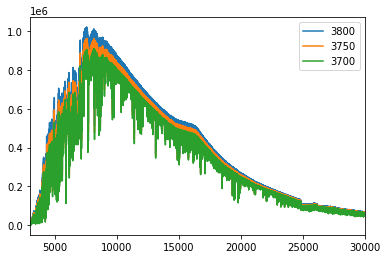

In [29]:
lambda0 = 100
nlambda = 99901
dlambda = 1
wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
spec1 = getspec(data,3800)
spec2 = getspec(data,3750)
spec3 = getspec(data,3700)
plt.plot(wave,spec1,label='3800')
plt.plot(wave,spec2,label='3750')
plt.plot(wave,spec3,label='3700')
plt.xlim(3000,30000)
plt.legend()
plt.show()

In [30]:
from scipy import interpolate

def convolve_filter(wav,spec,fwave,ftrans):
    ## interpolate the spectra
    interpfunc = interpolate.interp1d(ftrans, fwave, kind='linear')
    match = interpfuc(spec1)
    flux = np.sum(spec*match)
    return(flux)

'mearth'

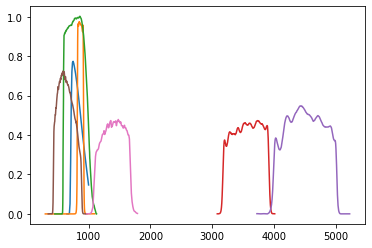

In [60]:
x,y = np.genfromtxt('filters/mearth.tsv', delimiter=';', unpack=True)
plt.plot(x,y, label='MEarth')
mearth = TabulatedFilter('mearth', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/pstr-zs-avg.txt', unpack=True)
plt.plot(x,y, label='zs')
zs = TabulatedFilter('zs', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/tess-response-function-v1.0.csv', unpack=True, comments='#', delimiter=',')
plt.plot(x,y, label='tess')
tess = TabulatedFilter('tess', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch1trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=1000
plt.plot(x,y, label='Sp1')
s1 = TabulatedFilter('S1', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch2trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=1000
plt.plot(x,y, label='Sp2')
s2 = TabulatedFilter('S2', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/Kepler_Kepler.K.dat', unpack=True, comments='#', delimiter=',')
x/=10
plt.plot(x,y, label='Kepler')
kepler = TabulatedFilter('Kepler', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/HST_WFC3_IR.G141.dat', unpack=True, comments='#', delimiter=' ')
x/=10
plt.plot(x,y, label='G141')
G141 = TabulatedFilter('G141', x[np.isfinite(y)], y[np.isfinite(y)])

## HST bands
b1 = [11108,11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042]
b2 = [11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042,16432]
b1 = [11108,11773.5,12439,13104.5,13770,14435.5,15101,15766.5]
b2 = [11773.5,12439,13104.5,13770,14435.5,15101,15766.5,16432]
nbins = np.size(b2)-1
tmp = np.linspace(10880,16800,nbins+1)
b1 = np.round(tmp[0:nbins])
b2 = np.round(tmp[1:nbins+1])
b1_num = np.array(b1)/10
b2_num = np.array(b2)/10
HST_bands = []
hst_names = np.array(b1,dtype=str)
for i in range(0,np.size(b1)):
    str1 = (to_str(round(b1[i])))
    str2 = (to_str(round(b2[i])))
    hst_names[i] = str(str1)+'--'+str(str2)                   
for i,j in zip(b1_num,b2_num):
    HST_bands = np.append(HST_bands,BoxcarFilter('HST1',i,j))

    
filters = [mearth,tess,s1,s2,HST_bands]
## wl (double-u el) and tm
#G141.__dict__.keys()
#print(G141.tm)

In [ ]:
## given depth (D), spot fraction (fS), and two spectra, compute the adjusted transit depth
def depth_adjust(filters,D,fS,wave,sp1,sp2,fname):
    